In [1]:
from __future__ import absolute_import, division, print_function

from hippylib import nb
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
%matplotlib inline

import logging
logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFC').setLevel(logging.ERROR)
dl.set_log_active(False)

sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')
from IPython.display import Image

# MUQ Includes
import pymuqModeling as mm # Needed for Gaussian distribution
import pymuqApproximation as ma # Needed for Gaussian processes
import pymuqSamplingAlgorithms as ms # Needed for MCMC

from PAT_forward import PAT_forward

# Hyperparameters

In [2]:
nx = ny = 10
mesh = dl.RectangleMesh(dl.Point(0, 0),dl.Point(1,1),nx,ny,"right")
V = dl.FunctionSpace(mesh, 'P', 1)
time_final = 9.5e-6
numSteps = 14
numObs = 10
c = 1500

# Synthetic Data 

In [3]:
fwdSolver = PAT_forward(time_final, numSteps, c, V, numObs)

# Prior
m = dl.interpolate(dl.Expression('0.5 * exp(-(x[0]-0.5)*(x[0]-0.5)/0.05 -(x[1]-0.5)*(x[1]-0.5)/0.05)', degree=2), V)
#logPriorMu = m.vector().get_local()
#logPriorCov = 0.02*np.eye(V.dim())
#logPrior = mm.Gaussian(logPriorMu, logPriorCov).AsDensity()

# Observation data
obsData = fwdSolver.Evaluate([m.vector().get_local()])[0]

# Prior

In [4]:
xDim=2;
yDim=1;

var = 0.7    # Marginal Variance
length = 1 # Lengthscale of the kernel
nu = 1.0/2.0 # Smoothness parameter

kern = ma.MaternKernel(xDim, var, length, nu)

mean = ma.LinearMean(np.zeros((1,xDim)), [0.25])

logPrior = ma.GaussianProcess(mean, kern).Discretize(mesh.coordinates().T).AsDensity()

# Likelihood

In [5]:
noiseVar = 1e-4
noiseCov = noiseVar*np.eye(obsData.shape[0])
likelihood = mm.Gaussian(obsData, noiseCov).AsDensity()

# Posterior

In [6]:
posteriorPiece = mm.DensityProduct(2)
p_0 = mm.IdentityOperator(V.dim())

In [7]:
graph = mm.WorkGraph()

# Forward model nodes and edges
graph.AddNode(p_0, "p_0")
#graph.AddNode(obsOperator, "B")
graph.AddNode(fwdSolver, "u")

graph.AddEdge("p_0", 0, "u", 0)
#graph.AddEdge("u", 0, "B", 0)

# Other nodes and edges
graph.AddNode(likelihood, "Likelihood")
graph.AddNode(logPrior, "Prior")
graph.AddNode(posteriorPiece,"Posterior")

#graph.AddEdge("B", 0, "Likelihood", 0)
graph.AddEdge("u", 0, "Likelihood", 0)
graph.AddEdge("p_0", 0, "Prior", 0)
graph.AddEdge("Prior",0,"Posterior",0)
graph.AddEdge("Likelihood",0, "Posterior",1)

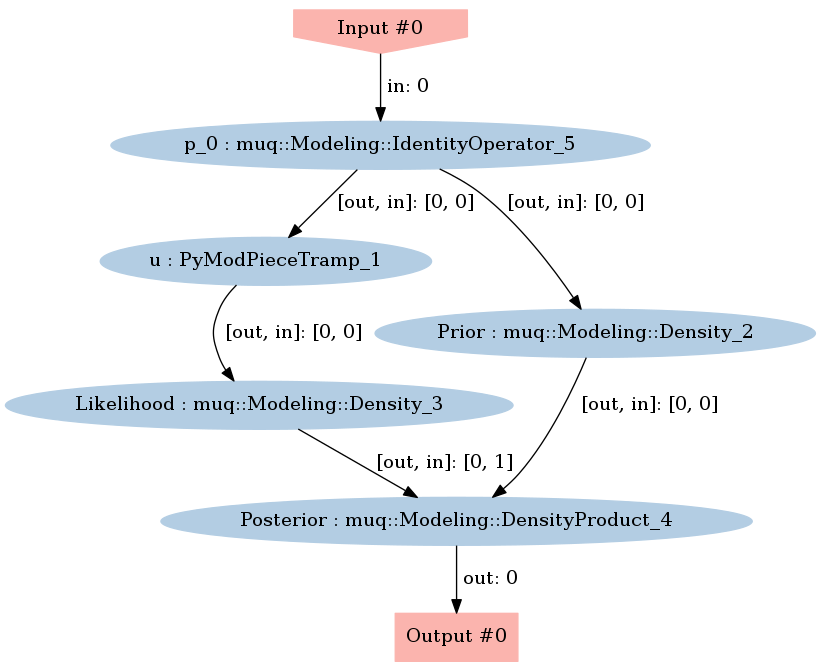

In [8]:
graph.Visualize("PosteriorGraph.png")
Image(filename='PosteriorGraph.png') 

In [9]:
problem = ms.SamplingProblem(graph.CreateModPiece("Posterior"))

In [10]:
'''
proposalOptions = dict()
proposalOptions['Method'] = 'AMProposal'
proposalOptions['ProposalVariance'] = 1e-1
proposalOptions['AdaptSteps'] = 100
proposalOptions['AdaptStart'] = 1000
proposalOptions['AdaptScale'] = 0.1

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 5000
options['ThinIncrement'] = 1
options['BurnIn'] = 1
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)
'''
# Setup pCN sampler
proposalOptions = dict()
proposalOptions['Method'] = 'CrankNicolsonProposal'
proposalOptions['Beta'] = 0.5
proposalOptions['PriorNode'] = 'Prior' #Needs to know where prior is to extract prior covariances

kernelOptions = dict()
kernelOptions['Method'] = 'MHKernel'
kernelOptions['Proposal'] = 'ProposalBlock'
kernelOptions['ProposalBlock'] = proposalOptions

options = dict()
options['NumSamples'] = 5000
options['ThinIncrement'] = 1
options['BurnIn'] = 10
options['KernelList'] = 'Kernel1'
options['PrintLevel'] = 3
options['Kernel1'] = kernelOptions

mcmc = ms.SingleChainMCMC(options,problem)

In [11]:
startPt = 0.25*np.ones(V.dim())
samps = mcmc.Run(startPt)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      Acceptance Rate = 0.2%
  20% Complete
    Block 0:
      Acceptance Rate = 0.1%
  30% Complete
    Block 0:
      Acceptance Rate = 0.2%
  40% Complete
    Block 0:
      Acceptance Rate = 0.15%
  50% Complete
    Block 0:
      Acceptance Rate = 0.12%
  60% Complete
    Block 0:
      Acceptance Rate = 0.1%
  70% Complete
    Block 0:
      Acceptance Rate = 0.11%
  80% Complete
    Block 0:
      Acceptance Rate = 0.1%
  90% Complete
    Block 0:
      Acceptance Rate = 0.089%
  100% Complete
    Block 0:
      Acceptance Rate = 0.08%
Completed in 248.36 seconds.


Effective Sample Size = 
 [  4.56066965   4.64949717   4.51614274   4.61391427   4.7932347
   4.57254572  11.92534073   4.47294114   5.03865982   4.77768742
   4.61334678   4.4874614    4.79654651   5.01318572   4.61519283
   4.50222558   4.71095143   5.23656574   5.61011318   4.46553623
   4.47377152   4.65681004   4.46887473   4.45089124   4.65889687
   4.74337191   4.65640698   4.70952324   4.52650466   4.81440012
   8.56260606   4.75275212   4.4862224    4.44409768   4.45945837
   4.80703143   5.09060768   4.73142327   4.5165482    4.48811615
   4.44138635   4.6686201    4.79411544   5.11737      4.46553106
   4.48513022   4.58912635   4.78105868   4.8994297    4.47902941
   4.44173914   4.48577624   4.62156164   4.49552771   4.56321466
   4.60273214   4.52764215   4.66307308   4.58272773   5.12252152
   4.77019482   4.63010983   4.49225167   4.53144277   4.51068346
   4.63094712   4.54228788   4.63484255   4.79288761   4.73881174
   4.88084146   8.10625804   4.51495576   4.4450142

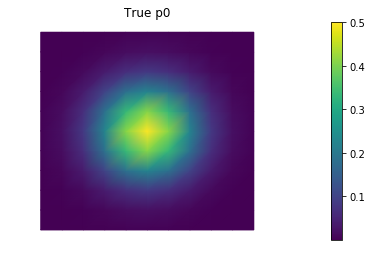

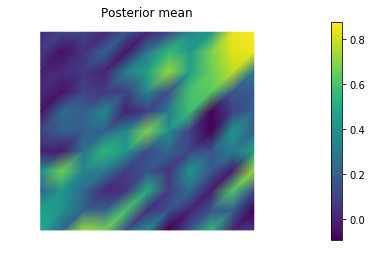

In [12]:
ess = samps.ESS()
print('Effective Sample Size = \n', ess)

sampMean = samps.Mean()
print('\nSample mean = \n', sampMean)

sampCov = samps.Covariance()
print('\nSample Covariance = \n', sampCov)

mcErr = np.sqrt( samps.Variance() / ess)
print('\nEstimated MC error in mean = \n', mcErr)

nb.plot(m)
plt.title("True p0")
plt.show()

m_post = dl.Function(V)
m_post.vector().set_local(sampMean)
nb.plot(m_post)
plt.title("Posterior mean")
plt.show()

In [13]:
sampMat = samps.AsMatrix()

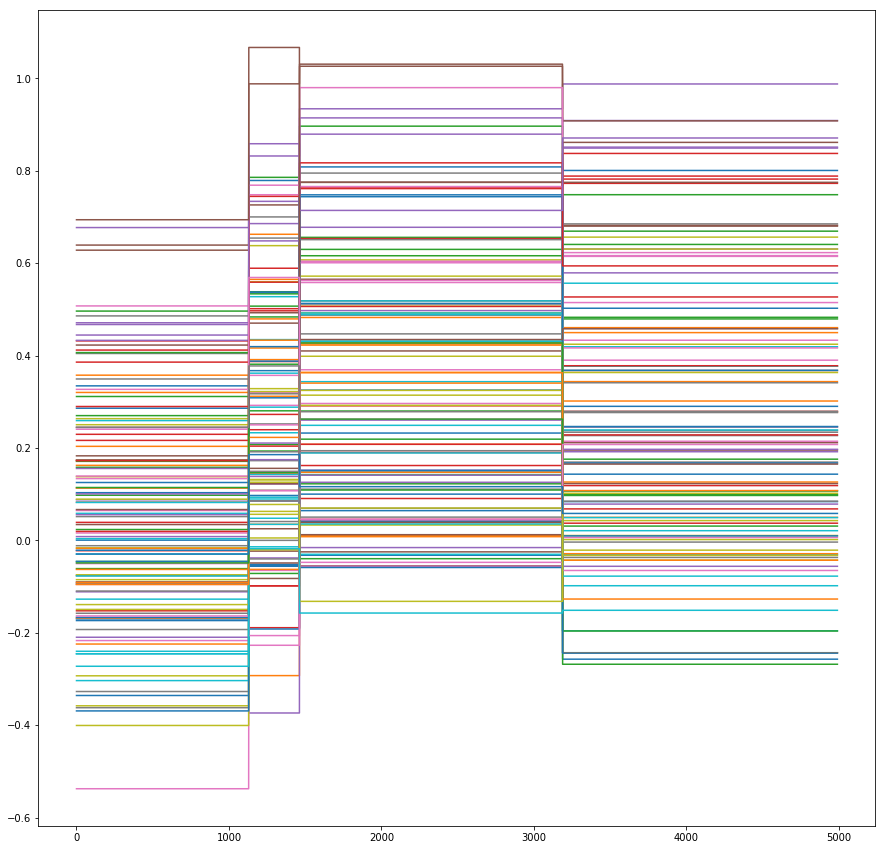

In [14]:
plt.figure(figsize=(15,15))
plt.plot(sampMat.T)
plt.show()

# Plot samples of the posterior predictive

In [15]:
#predSamps = np.zeros((numPts, sampMat.shape[1]))

#predModel = graph.CreateModPiece("u")

#for i in range(sampMat.shape[1]):
#    predSamps[:,i] = predModel.Evaluate([ sampMat[:,i] ])[0]